# Clone gym-solitaire repository to make the interface

In [2]:
!git clone https://github.com/taylorjg/gym-solitaire.git

Cloning into 'gym-solitaire'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 83 (delta 32), reused 73 (delta 22), pack-reused 0
Receiving objects: 100% (83/83), 12.91 KiB | 2.58 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [1]:
import os
os.chdir("/content/gym-solitaire")
%ls

gym_solitaire/           main.py    requirements.txt
gym_solitaire.egg-info/  README.md  setup.py


In [2]:
!pip3 install -e .

Obtaining file:///content/gym-solitaire
  Preparing metadata (setup.py) ... done
  Attempting uninstall: gym-solitaire
    Found existing installation: gym-solitaire 0.0.1
    Uninstalling gym-solitaire-0.0.1:
      Successfully uninstalled gym-solitaire-0.0.1
  Running setup.py develop for gym-solitaire


# Import Libraries

In [3]:
import argparse
import numpy as np
import gym
import random
from gym_solitaire.envs import obs_to_board, board_to_obs
import matplotlib as mpl
import matplotlib.pyplot as plt

In [122]:
import warnings
warnings.filterwarnings("ignore")

In [102]:
LR = 0.001
EPSILON_START = 1
EPSILON_END = 0.01
EPSILON_DECAY_PC = 50
GAMMA = 1
NUM_EPISODES = 20000
BATCH_SIZE = 64
PATH = "td_solitaire.h5"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
env = gym.make('gym_solitaire:gym_solitaire-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
in_dim = env.observation_space.shape[0]
in_dim

33

# Define the Neural Network

In [7]:
import tensorflow as tf

class Net(tf.keras.Model):
    def __init__(self, in_dim):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(in_dim,)),
            tf.keras.layers.Dense(1)
        ])

    def call(self, x):
        return self.model(x)

In [103]:
net = Net(in_dim)

In [32]:
def fst(pair):
    return pair[0]

def snd(pair):
    return pair[1]

def evaluate_valid_actions(net, s):
    current_board = obs_to_board(s)

    def evaluate_valid_action(a):
        new_board = current_board.make_move(a)
        s2 = board_to_obs(new_board)
        return s2

    valid_actions = current_board.valid_actions()
    s2s = list(map(evaluate_valid_action, valid_actions))

    s2_values = net(tf.constant(s2s, dtype=tf.float32)).numpy().squeeze(-1)
    s2_value_a_pairs = list(zip(s2_values, valid_actions))

    return s2_value_a_pairs


def make_policy(net):
    def pi(s, epsilon=0):
        s2_value_a_pairs = evaluate_valid_actions(net, s)
        if random.random() < epsilon:
            return random.choice(s2_value_a_pairs)
        else:
            best_pair = s2_value_a_pairs[0]
            for pair in s2_value_a_pairs[1:]:
                if fst(pair) > fst(best_pair):
                    best_pair = pair
            return best_pair

    return pi

In [107]:
pi = make_policy(net)

In [108]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=LR)

In [109]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

In [111]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
net.compile(optimizer=optimizer, loss=custom_loss)

In [115]:
def make_linear_decay_schedule(start_val, end_val, decay_pc):
    range_val = end_val - start_val
    decay_episodes = NUM_EPISODES * decay_pc / 100
    per_episode_delta = range_val / decay_episodes

    def linear_decay_schedule(episode):
        if episode > decay_episodes:
            return end_val
        else:
            return start_val + per_episode_delta * episode

    return linear_decay_schedule

def train(env, pi, net, loss_fn, opt):
    epsilon_decay_schedule = make_linear_decay_schedule(EPSILON_START, EPSILON_END, EPSILON_DECAY_PC)
    episode_rewards = []  # To store rewards for each episode
    episode_states = []   # To store states for each episode
    episode_targets = []  # To store targets for each episode

    for episode in range(NUM_EPISODES):
        epsilon = epsilon_decay_schedule(episode)
        state = env.reset()
        episode_states.append([])  # Create an empty list for the current episode's states
        episode_targets.append([])  # Create an empty list for the current episode's targets

        while True:
            s2_value, a = pi(state, epsilon)

            next_state, reward, done, _ = env.step(a)

            s_value = net(np.array([state], dtype=np.float32)).numpy().squeeze()

            s2_value_target = reward + (1 - done) * GAMMA * s2_value

            episode_states[-1].append(state)
            episode_targets[-1].append(s2_value_target)

            if done:
                episode_rewards.append(np.sum(episode_targets[-1]))  # Store total reward for the episode
                break

            state = next_state

    states = [state for episode in episode_states for state in episode]
    targets = [target for episode in episode_targets for target in episode]

    states = np.array(states, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((states, targets)).shuffle(buffer_size=len(states))

    history = net.fit(dataset.batch(BATCH_SIZE), epochs=100)

    return history


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
history = train(env, pi, net, loss_fn, opt)

Epoch 1/100
7892/7892 [==============================] - 17s 2ms/step - loss: 10.0302
Epoch 2/100
7892/7892 [==============================] - 17s 2ms/step - loss: 8.4754
Epoch 3/100
7892/7892 [==============================] - 17s 2ms/step - loss: 8.1191
Epoch 4/100
7892/7892 [==============================] - 18s 2ms/step - loss: 7.8886
Epoch 5/100
7892/7892 [==============================] - 19s 2ms/step - loss: 7.7378
Epoch 6/100
7892/7892 [==============================] - 17s 2ms/step - loss: 7.6291
Epoch 7/100
7892/7892 [==============================] - 17s 2ms/step - loss: 7.5377
Epoch 8/100
7892/7892 [==============================] - 18s 2ms/step - loss: 7.4659
Epoch 9/100
7892/7892 [==============================] - 18s 2ms/step - loss: 7.3826
Epoch 10/100
7892/7892 [==============================] - 17s 2ms/step - loss: 7.2996
Epoch 11/100
7892/7892 [==============================] - 17s 2ms/step - loss: 7.2323
Epoch 12/100
7892/7892 [==============================] - 17s 

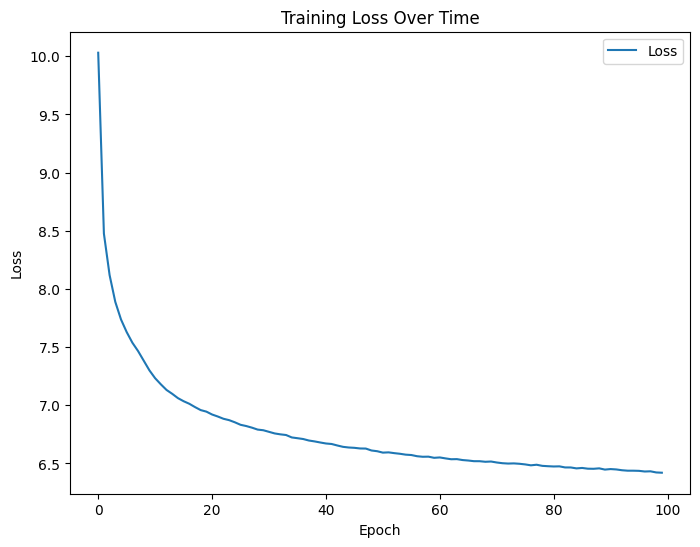

In [117]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [118]:
def play(env, pi):
    actions = []
    s = env.reset()
    while True:
        _, a = pi(s)
        actions.append(a)
        s2, _, done, _ = env.step(a)
        if done:
            print(f"actions: {actions}")
            env.render()
            break
        s = s2

In [119]:
net.save_weights("../best_model.h5")

In [123]:
play(env, pi)

actions: [68, 19, 31, 5, 38, 30, 11, 32, 0, 4, 22, 29, 64, 61, 74, 57, 65, 44, 49, 71, 56, 47]
  X.X  
  .X.  
..X.X.X
...X...
..X.X..
  ...  
  .X.  

